### Initial Stuff

In [1]:
import torch
import torchvision
import iecdt_lab
# import train_autoencoder
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tqdm
import numpy as np
# import os
import yaml
import json
%matplotlib inline

In [2]:
TILES_FILE = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_numpy"
TEST_METADATA = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_test.csv"
TILES_STATISTICS = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz"

# The Autoencoder

## Autoencoder Structure and Training Algorithm

Autoencoder is currently symmetric, with the decoder being structured inversely to the encoder:

The encoder has:

3 convolution layers (with relu activation functions) and 1 fully connected linear layer (no activation function afterwards).

Convolution all have:
* kernel size = 3
* stride = 3 
* padding = 1

First, second, and third convolutions output a batch size of 32, 64, and 128, respectively.

Fully connected linear layer compresses flattened output of previous layer into an array of size `latent_dim` (default is 128), which is then wacked into a sigmoid.


It is optimised using adam optimising a MSELoss (divided by batch size) between the input and output images.

The default training hyperparameters are:
* epoch num = 10
* batch size = 128
* learning rate = 0.001

## Autoencoder Performance

In [3]:
#Specify device
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

"""Specify the path to the autoencoder you want here:"""
model_dir = "logs/test/runs/2026-02-11_16-57-03"

#Read of model configuration.
path_to_config = model_dir+'/.hydra/config.yaml'

with open(path_to_config) as stream:
    try:
        print(json.dumps(yaml.safe_load(stream), indent=4))
    except yaml.YAMLError as exc:
        print(exc)

cuda
{
    "name": "test",
    "smoke_test": false,
    "seed": 0,
    "device": "cuda",
    "log_freq": 10,
    "epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 128,
    "max_pooling": false,
    "sigmoid": true,
    "stride": 3,
    "latent_dim": 128,
    "dataloader_workers": 1,
    "load_tiles": true,
    "tiles_path": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_numpy",
    "train_metadata": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_train.csv",
    "val_metadata": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_val.csv",
    "train_rgb_stats": "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz",
    "wandb": {
        "mode": "offline",
        "project": "iecdt_deep_learning_lab"
    }
}


In [4]:
'''YOU WILL HAVE TO MANUALLY SPECIFY THE MODEL INFO. JUST READ OFF THE INFO ABOVE'''

#Specify model info
latent_dim=128
max_pooling=False
sigmoid = True
stride = 3

path_to_model = model_dir+"/model.pth"

model = iecdt_lab.autoencoder.CNNAutoencoder(
    latent_dim=latent_dim,                          #<----- CHANGE THESE DEPENDING ON MODEL
    max_pooling=max_pooling,                        #<----- CHANGE THESE DEPENDING ON MODEL
    sigmoid=sigmoid,                                #<----- CHANGE THESE DEPENDING ON MODEL
    stride=stride                                   #<----- CHANGE THESE DEPENDING ON MODEL
)

model.load_state_dict(torch.load(path_to_model,map_location=device,weights_only=True))
model = model.to(device)
model.eval()

CNNAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=131072, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=131072, bias=True)
    (conv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

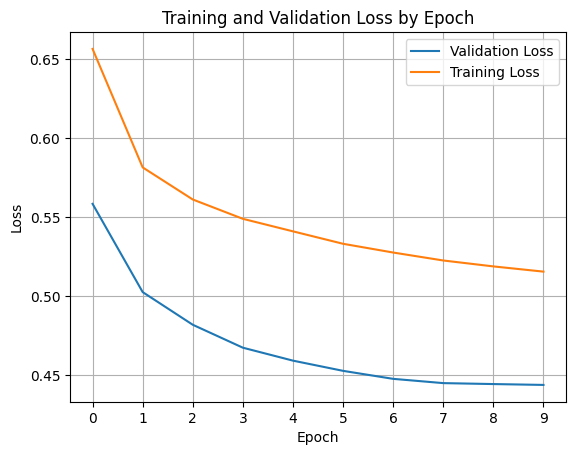

In [5]:
path_to_val_error = model_dir+'/val_error.csv'
path_to_train_error = model_dir+'/tra_error.csv'

val_error = np.genfromtxt(path_to_val_error, delimiter=',')
tra_error = np.genfromtxt(path_to_train_error, delimiter=',')

fig,ax = plt.subplots()

ax.plot(val_error,label='Validation Loss')
ax.plot(tra_error,label='Training Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid()
ax.set_title('Training and Validation Loss by Epoch')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

### Display Example Reconstruction Images (UNCOMMENT TO DISPLAY)

In [6]:
# path_to_images = path_to_logs+'/files/media/images'

# Epoch=1
# for image_path in os.listdir(path_to_images):
#     print(f'Epoch = {Epoch}')
#     display(Image(path_to_images+'/'+image_path))
#     Epoch+=1

# Compute Autoencoder Embeddings

In [7]:
data_stats = np.load(TILES_STATISTICS)
data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=data_stats["rgb_mean"], std=data_stats["rgb_std"]
        ),
    ]
)
test_ds = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
    transform=data_transforms,
)
test_data_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=True,
    num_workers=16,
)

Remove the decoder of the autoencoder so the model outputs the embeddings before the final layer.

In [8]:
embedding_model = torch.nn.Sequential(*list(model.children())[:-1])
embedding_model.eval()

Sequential(
  (0): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=131072, out_features=128, bias=True)
  )
)

Compute the actual embeddings for all of the test dataset. This cell will take a couple of minutes to run!

In [9]:
embeddings = []
for batch, labels in tqdm.tqdm(test_data_loader):
    with torch.no_grad():
        batch = batch.to(device) #Make sure that the batch datatype matches the model datatype
        embeddings.append(embedding_model(batch).to('cpu').numpy()) #Need to be cpu type to save as numpy file
embeddings = np.concatenate(embeddings, axis=0)
embeddings = embeddings.reshape(embeddings.shape[0], -1)
print(embeddings.shape)

100%|██████████| 58/58 [00:08<00:00,  6.76it/s]

(3696, 128)


# Cluster the Embeddings

In [10]:
def plot_cluster_tiles(cluster_labels, tile_dataset, num_samples=5) -> plt.Figure:
    """Plot the clusters of the test tiles. Each column is a cluster."""
    num_clusters = len(np.unique(cluster_labels))
    fig, axs = plt.subplots(
        num_samples, num_clusters, figsize=(num_clusters * 2, num_samples * 2)
    )
    for i in range(num_clusters):
        cluster_ixs = np.where(cluster_labels == i)[0]
        for j in range(num_samples):
            if j < len(cluster_ixs):
                tile, _ = tile_dataset[cluster_ixs[j]]
                axs[j, i].imshow(tile)
            axs[j, i].axis("off")

        axs[0, i].set_title(f"Cluster {i}")

    fig.tight_layout()
    return fig

def plot_clusters(cluster_labels, pca_embeddings) -> plt.Figure:
    """Plot the clusters in the PCA space."""
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in np.unique(cluster_labels):
        cluster_ixs = np.where(cluster_labels == i)[0]
        ax.scatter(
            pca_embeddings[cluster_ixs, 0],
            pca_embeddings[cluster_ixs, 1],
            label=f"Cluster {i}",
        )
    ax.legend()
    return fig

To get some understanding of how the embedding space is structured we will first reduce the embedding dimensionality using principal component analysis (PCA) and then cluster using KMeans. Feel free to experiment with different dimensionality reduction methods and clustering algorithms!

## Final Clustering and Dimensionality Reduction Code

I can't actually run the code locally, so I have put it through a couple of sweeps of the oracle asking it to fix possible mistakes - hopefully this is sufficient but sorry if when we run it this afternoon there are errors.

In [ ]:
from sklearn.metrics import silhouette_samples

# PCA and KMeans values
pca_values = [2] + list(np.round(np.arange(0.85, 1.00, 0.02), 2))  # [2, 0.85, 0.87, ..., 0.99]
k_values = [2, 4, 6, 8, 10]

# Store output
pca_list = []
k_list = []
avg_sil_list = []
cluster_sil_means_list = []  # mean silhouette score for each combination
per_sample_silhouettes_list = []  # all silhouette scores for each combination

for pca_n in pca_values:
    # PCA
    print(f"\n=== PCA: n_components = {pca_n} ===")
    pca = PCA(n_components=pca_n)
    pca_embeddings = pca.fit_transform(embeddings)

    for k in k_values:
        print(f"\n--- KMeans: n_clusters = {k} ---")
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(pca_embeddings)
        cluster_labels = kmeans.predict(pca_embeddings)

        # Silhouette scores per sample on PCA_Embeddings!!!! I was calculating it on the normal embeddings before!
        sil_samples = silhouette_samples(pca_embeddings, cluster_labels)

        # Per-cluster silhouette means, this bit was the oracale I hope it works
        unique_clusters = np.unique(cluster_labels)
        per_cluster_means = np.array([sil_samples[cluster_labels == c].mean() for c in unique_clusters])

        # Average silhouette (overall mean)
        overall_silhouette = sil_samples.mean()

        # Save results
        pca_list.append(pca_n)
        k_list.append(k)
        avg_sil_list.append(overall_silhouette)
        cluster_sil_means_list.append(per_cluster_means)
        per_sample_silhouettes_list.append(sil_samples)

        # Print results
        print(f"PCA n_components = {pca_n}, K = {k}")
        for idx_c, mean_val in enumerate(per_cluster_means):
            print(f"  Cluster {idx_c}: silhouette mean = {mean_val:.4f}")
        print(f"  -> Average silhouette score (overall): {overall_silhouette:.4f}")
        print("-" * 40)  # I like neat demarcation

# Convert to numpy arrays now that appending is done, I was lazy and used lists
pca_arr = np.array(pca_list)
k_arr = np.array(k_list)
avg_sil_arr = np.array(avg_sil_list)
# I can't run the code but in an oracle sweep apparently the below needed a dtype=object
cluster_sil_means_arr = np.array(cluster_sil_means_list, dtype=object)
per_sample_silhouettes_arr = np.array(per_sample_silhouettes_list, dtype=object)



# Find highest average silhouette
best_idx = np.argmax(avg_sil_arr)
best_pca = pca_arr[best_idx]
best_k = k_arr[best_idx]
best_avg_sil = avg_sil_arr[best_idx]
best_cluster_means = cluster_sil_means_arr[best_idx]
print("\n" + "-" * 40)
print("Best average silhouette score:")
print(f"  PCA n_components = {best_pca}")
print(f"  KMeans n_clusters = {best_k}")
print(f"  Average silhouette = {best_avg_sil:.4f}")
for idx_c, mean_val in enumerate(best_cluster_means):
    print(f"    Cluster {idx_c}: silhouette mean = {mean_val:.4f}")
print("-" * 40 + "\n")

# Visualise
# PCA on x, silhouette on y, each line is a k value
plt.figure(figsize=(10, 6))
unique_k = sorted(set(k_values))
for k in unique_k:
    mask = (k_arr == k)
    x = np.array([float(v) for v in pca_arr[mask]])  # convert PCA labels to numeric floats (2 and floats)
    y = avg_sil_arr[mask]
    # sort by x
    if len(x) > 0:
        order = np.argsort(x)
        x_sorted = x[order]
        y_sorted = y[order]
        plt.plot(x_sorted, y_sorted, marker='o', label=f'K={k}')
plt.xlabel('PCA n_components (2 or explained variance)') # I might get rid of the 2 in general and just do explained variance
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette vs PCA n_components (one line per KMeans Value)')
plt.legend()
plt.grid(True)
plt.show()


# Plot clusters and tiles for the best run
print("Cluster plots for best run")
pca_best = PCA(n_components=best_pca)
pca_embeddings_best = pca_best.fit_transform(embeddings)
kmeans_best = KMeans(n_clusters=int(best_k), random_state=0, n_init=10).fit(pca_embeddings_best)
cluster_labels_best = kmeans_best.predict(pca_embeddings_best)

# Scatter plot in PCA space using helper
fig1 = plot_clusters(cluster_labels_best, pca_embeddings_best)
fig1.suptitle(f'Clusters in PCA space (PCA={best_pca}, K={best_k})', y=1.02)
plt.show()

# Tile samples using helper dataset without transforms
test_ds_no_transform = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
)
fig2 = plot_cluster_tiles(cluster_labels_best, test_ds_no_transform, num_samples=5)
fig2.suptitle(f'Example tiles per cluster (PCA={best_pca}, K={best_k})', y=1.02)
plt.show()


In [11]:
# pca = PCA(n_components=0.92)
# pca_embeddings = pca.fit_transform(embeddings)

# kmeans = KMeans(n_clusters=5, random_state=0).fit(pca_embeddings)
# cluster_labels = kmeans.predict(pca_embeddings)

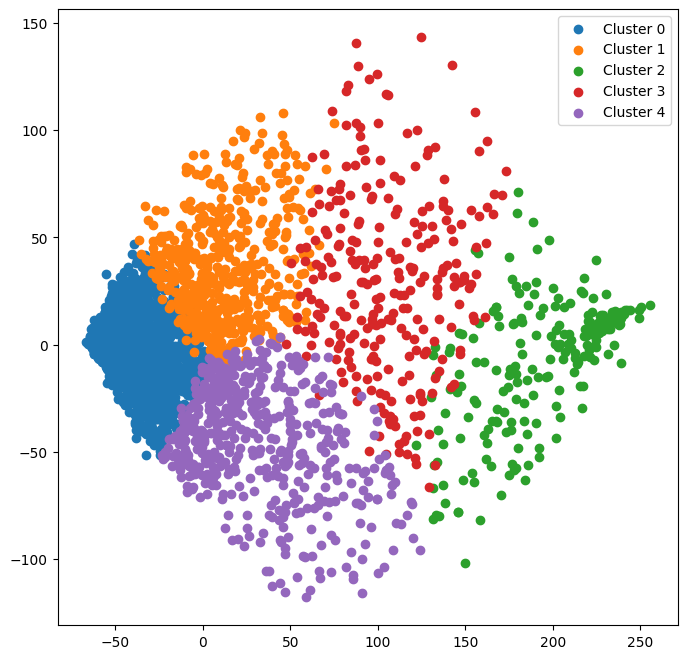

In [12]:
# _ = plot_clusters(cluster_labels, pca_embeddings)

In [13]:
# test_ds_no_transform = iecdt_lab.data_loader.GOESRGBTiles(
#     tiles_file=TILES_FILE,
#     metadata_file=TEST_METADATA,
# )

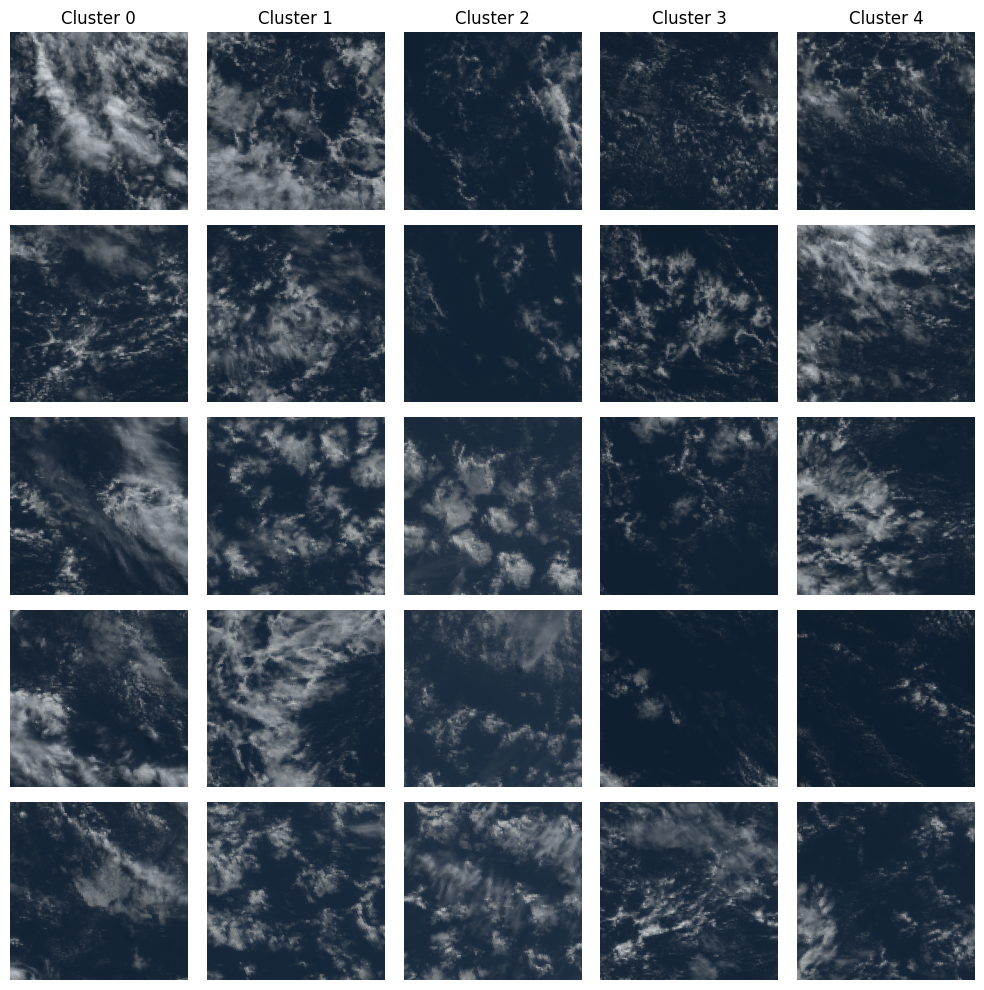

In [14]:
# _ = plot_cluster_tiles(cluster_labels, test_ds_no_transform, num_samples=5)

In [15]:
# from sklearn.metrics import silhouette_samples


# # Silhouette for each sample
# sil_samples = silhouette_samples(embeddings, cluster_labels)

# # Per-cluster silhouette
# unique_clusters = np.unique(cluster_labels)
# cluster_silhouettes = {}

# for c in unique_clusters:
#     cluster_silhouettes[c] = sil_samples[cluster_labels == c].mean()
#     print(f"Cluster {c}: silhouette = {cluster_silhouettes[c]:.4f}")

# # Average silhouette
# overall_silhouette = sil_samples.mean()
# print(f"Mean silhouette score: {overall_silhouette:.4f}")

Cluster 0: silhouette = 0.3597
Cluster 1: silhouette = -0.1296
Cluster 2: silhouette = 0.3103
Cluster 3: silhouette = -0.0557
Cluster 4: silhouette = -0.0982
Mean silhouette score: 0.1893
